# Compas
The study claimed that african-american defendants were more likely than white defendants to be incorrectly classified at a high risk of recidivism.

The dataset has been discretized to have a binary class, attributes have been removed and discretized as well.

```
@relation class
@attribute sex { Female,Male }
@attribute age_cat { 25-55,Over45,Under25 }
@attribute race { African-American,Asian,Caucasian,Hispanic,'Native American',Other }
@attribute priors_count { 0-2,2-4,4-8,<0,≥8 }
@attribute days_b_screening_arrest { 0-2,14-52,2-14,<0,≥52 }
@attribute c_charge_degree { F,M }
@attribute is_recid { 0,1 }
@attribute is_violent_recid { 0,1 }
@attribute two_year_recid { 0,1 }
@attribute length_of_stay { 0-2,2-6,6-34,<0,≥34 }
@attribute class { High,Medium-Low }
```

In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')
plt.rc('text', usetex=False)
plt.rc('figure', figsize=[10, 10])
plt.rc('font', size=18)

In [39]:
import random
from os.path import join
from typing import Tuple, List

import arff
from snapshottest import TestCase

from src import DEFAULT_DIR
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset


def load_arff(f):
    a = arff.load(f)
    dataset = Dataset(a['data'], a['attributes'])

    return dataset


def import_datasets_arff(f, f_explain, explain_indices: List[int],
                         random_explain_dataset: bool) -> Tuple[Dataset, Dataset, List[str]]:
    train_dataset = load_arff(f)
    explain_dataset = load_arff(f_explain)

    len_explain_dataset = len(explain_dataset)

    if random_explain_dataset:
        random.seed(7)
        explain_indices = list(random.sample(range(len_explain_dataset), 300))
        explain_dataset = Dataset.from_indices(explain_indices, explain_dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]


def get_classifier(classifier_name: str):
    if classifier_name == "Categorical Naive Bayes":
        from sklearn.naive_bayes import CategoricalNB

        skl_clf = CategoricalNB()

        return skl_clf

    if classifier_name == "Random Forest":
        from sklearn.ensemble import RandomForestClassifier

        skl_clf = RandomForestClassifier(random_state=42)

        return skl_clf

    if classifier_name == "Neural Network":
        from sklearn.neural_network import MLPClassifier
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import OneHotEncoder

        pipe = make_pipeline(OneHotEncoder(), MLPClassifier(random_state=42, max_iter=1000))
        skl_clf = pipe

        return skl_clf
  
    raise ValueError("Classifier not available")

def evaluate(cln):
    from sklearn.metrics import accuracy_score
    with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d.arff")) as f:
        with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d_explain.arff")) as f_explain:
            train_dataset, explain_dataset, explain_indices = import_datasets_arff(f, f_explain, [], True)

    clf = get_classifier(cln).fit(train_dataset.X_numpy(), train_dataset.Y_numpy())
    return accuracy_score(clf.predict(explain_dataset.X_numpy()), explain_dataset.Y_numpy())
    

def get_explanation(ix:int, classifier_name: str, manual_target_class=None):
    with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d.arff")) as f:
        with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d_explain.arff")) as f_explain:
            train_dataset, explain_dataset, explain_indices = import_datasets_arff(f, f_explain, [], True)

    clf = get_classifier(classifier_name).fit(train_dataset.X_numpy(), train_dataset.Y_numpy())
    explainer = XPLAIN_explainer(clf, train_dataset)

    instance = explain_dataset.get_decoded(ix)

    cc = explain_dataset.class_column_name()
    decoded_target_class = instance[cc]

    return explainer.explain_instance(
        explain_dataset[ix],
        manual_target_class if manual_target_class != None else decoded_target_class
    )

def get_probabilities(i, ds, cln):
    from sklearn.metrics import accuracy_score
    with open(ds) as f:
            train_dataset, explain_dataset, explain_indices = import_dataset_arff(
                f, [], True)

    clf = get_classifier(cln).fit(train_dataset.X_numpy(), train_dataset.Y_numpy())
    return clf.predict_proba([explain_dataset.X_numpy()[i]])

In [64]:
def plot(e):

    fig, pred_ax = plt.subplots(1, 1)
    
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    nls = ",\n".join(values)
    
    pred_ax.set_title(
f"""Importance
P[y={e['target_class']} | x=({nls})]={e['prob']:.3f}""", pad=12
    )
    pred_ax.set_ylabel("Attribute or rule", labelpad=2)
    pred_ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x A_i]$",labelpad=12)
    
    pred_ax.grid(True)
    
    pred_ax.barh(
        attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

In [28]:
with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d.arff")) as f:
        with open(join(DEFAULT_DIR, "datasets/compas-scores-two-years_d_explain.arff")) as f_explain:
            train_dataset, explain_dataset, explain_indices = import_datasets_arff(f, f_explain, [], True)

# Naive Bayes 

In [32]:
evaluate("Categorical Naive Bayes")

0.7433333333333333

In [52]:
explain_dataset.get_decoded(0)

sex                                    Male
age_cat                               25-55
race                       African-American
priors_count                             <0
days_b_screening_arrest                 0-2
c_charge_degree                           F
is_recid                                  0
is_violent_recid                          0
two_year_recid                            0
length_of_stay                          0-2
class                            Medium-Low
Name: 1326, dtype: object

compute_lace_step k=63
compute_lace_step k=126
compute_lace_step k=189
explain_instance errors: 1.321E-01, 1.321E-01, 1.565E-01


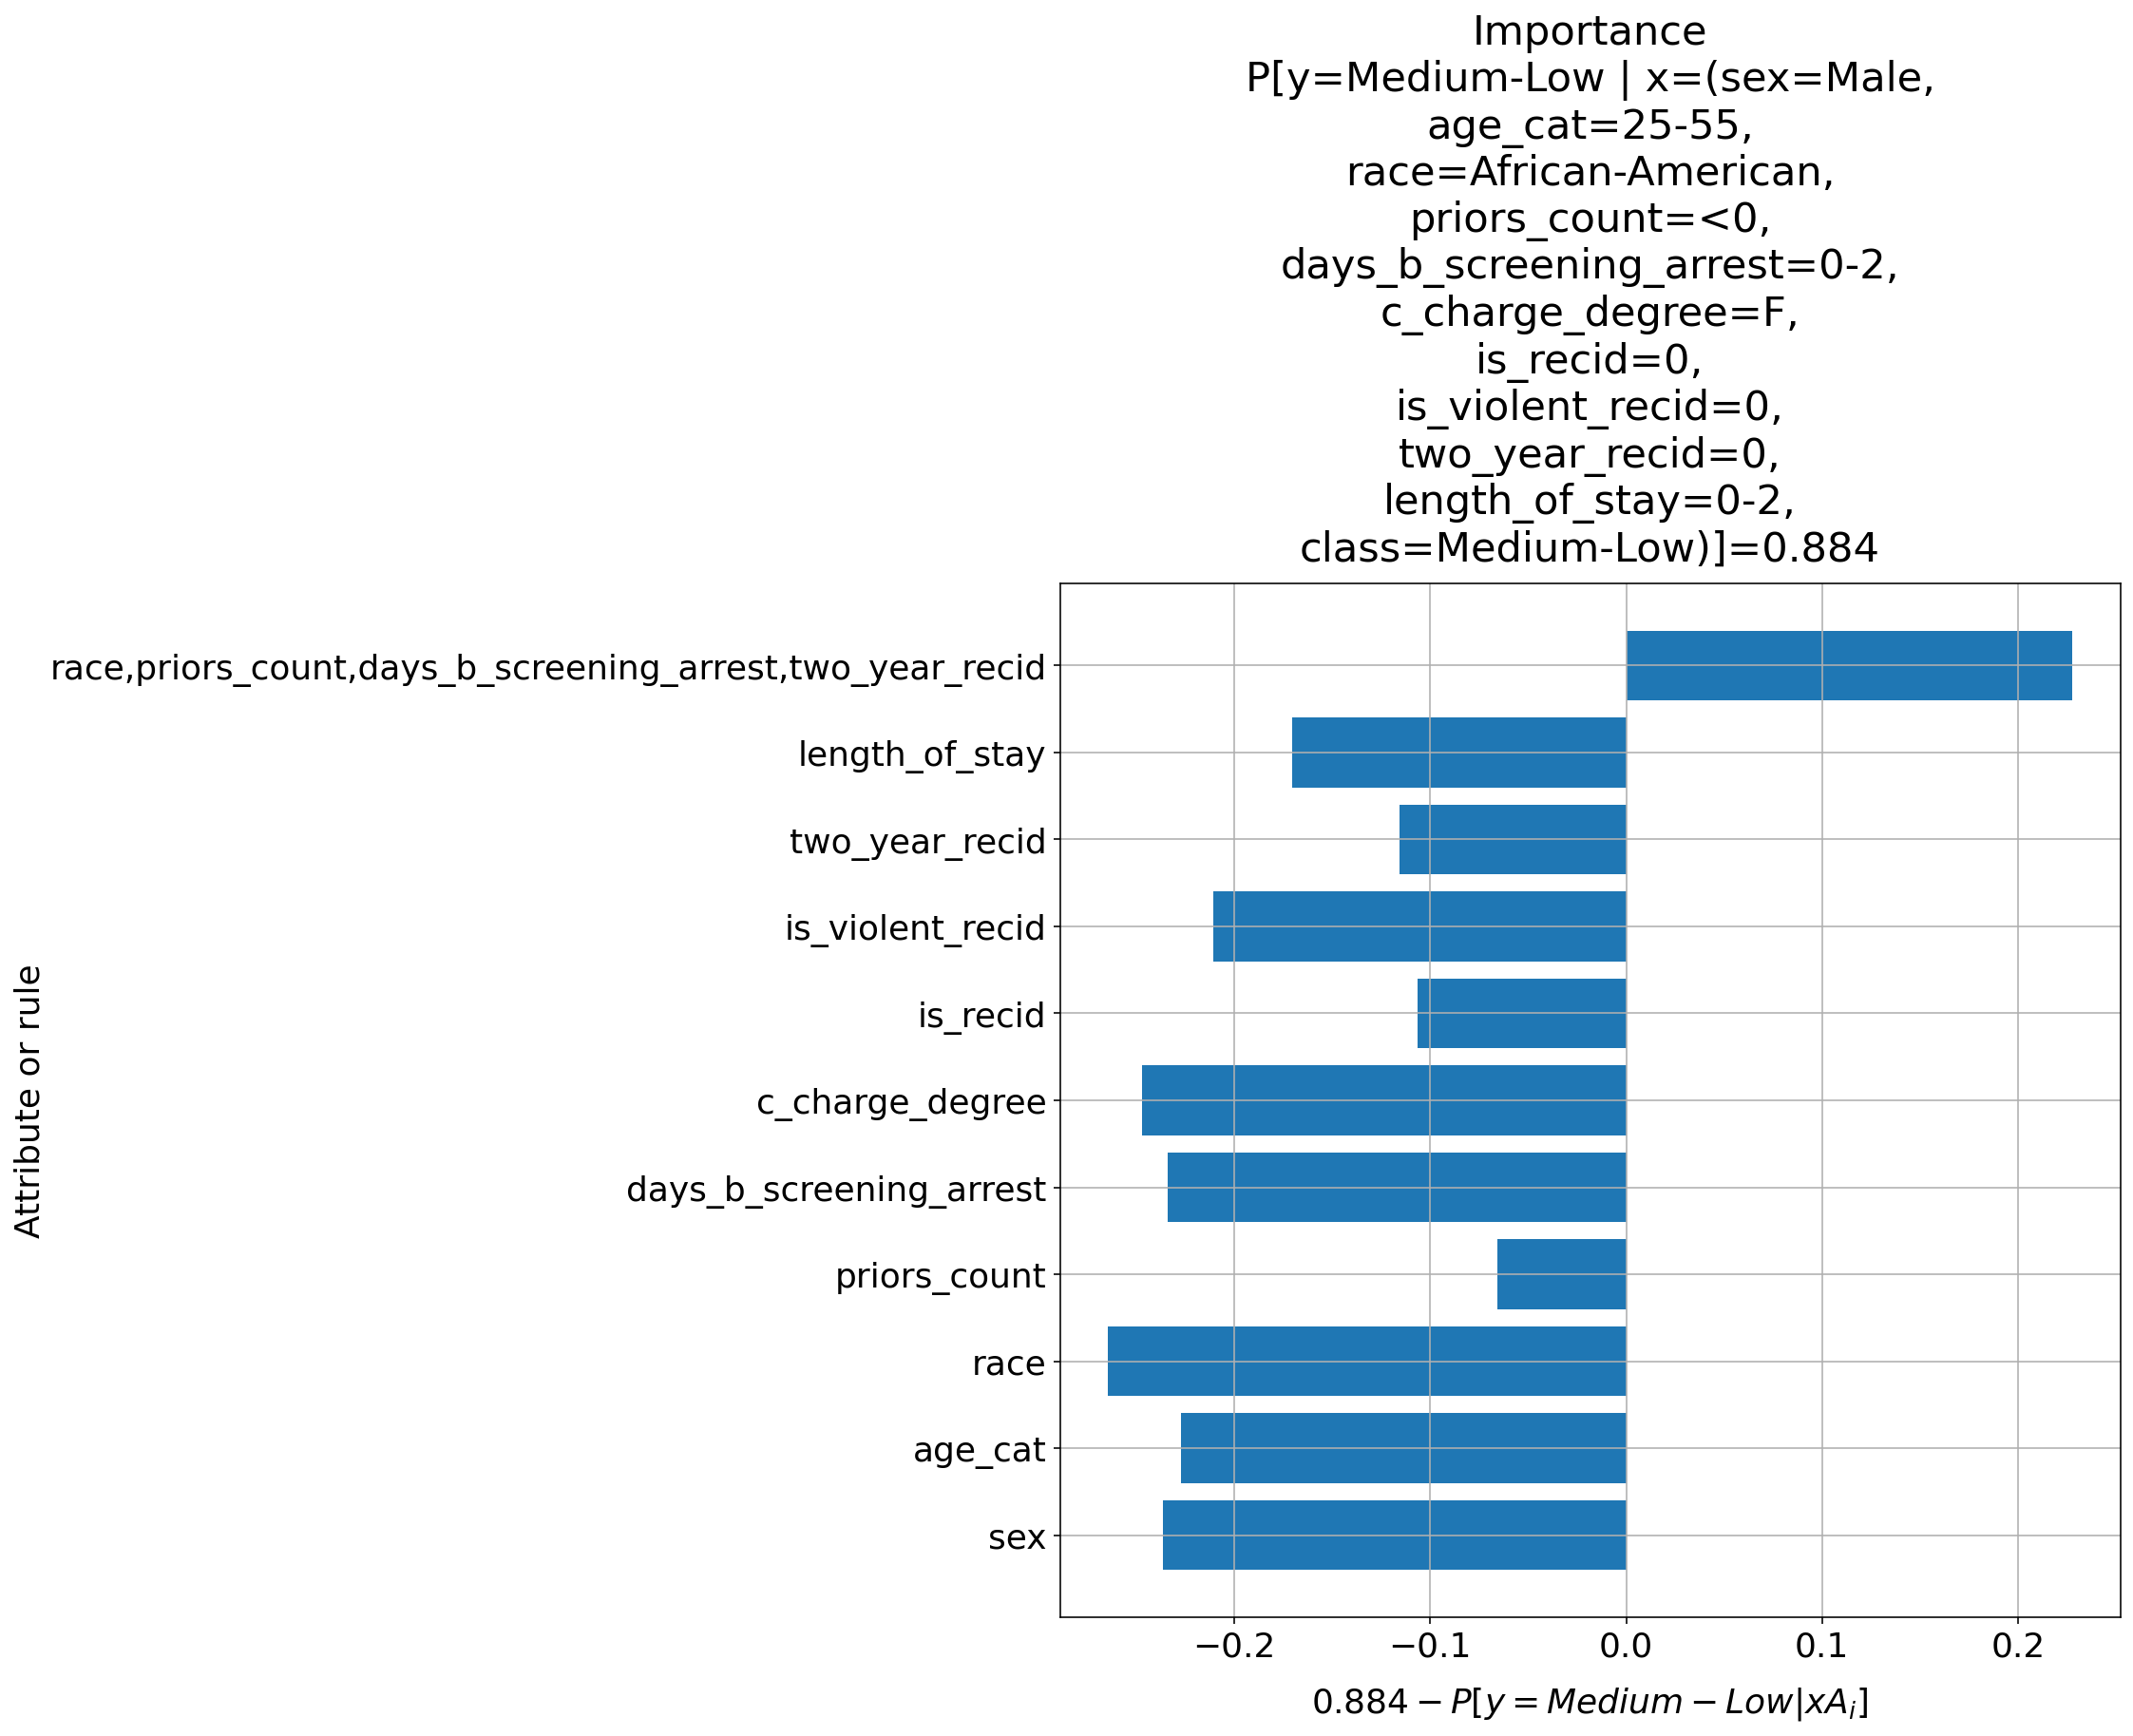

In [65]:
plot(get_explanation(0, "Categorical Naive Bayes"))

# Random Forest 

In [35]:
evaluate("Random Forest")

0.7233333333333334

compute_lace_step k=63
compute_lace_step k=126
explain_instance errors: 6.034E-02, 1.934E-02


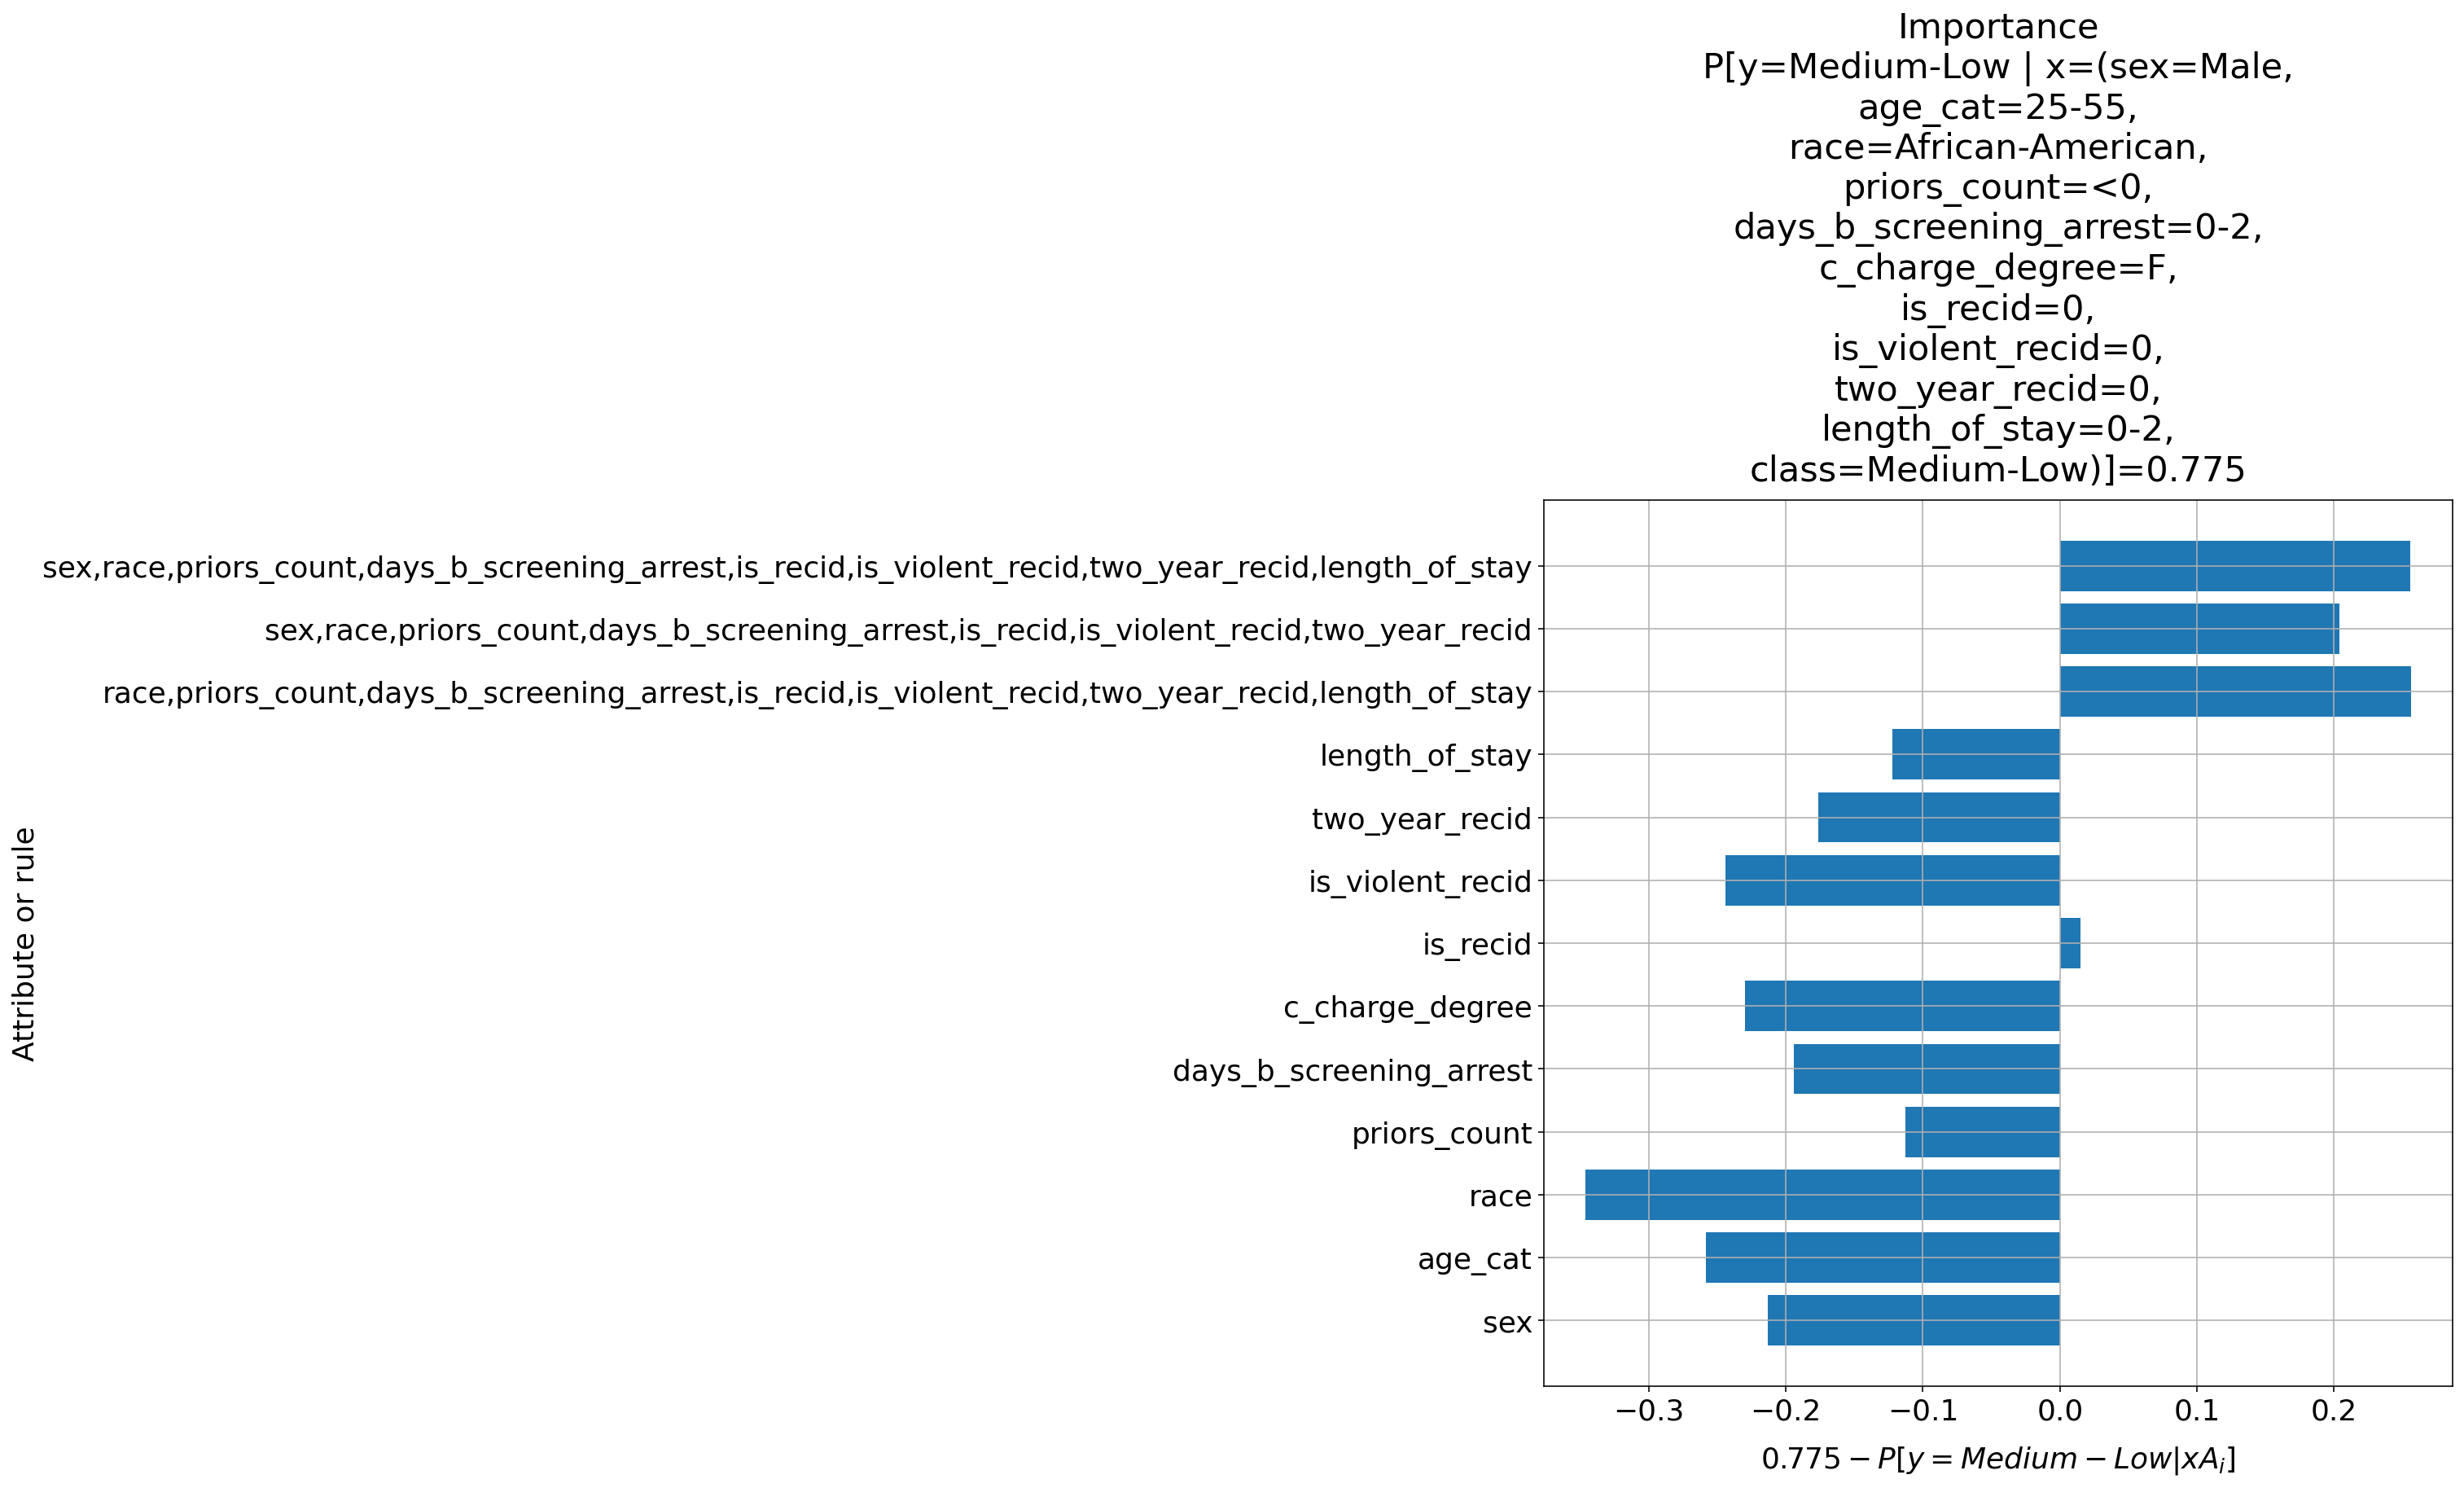

In [67]:
plot(get_explanation(0, "Random Forest"))

In [34]:
evaluate("Neural Network")

0.7033333333333334